In [5]:
#pip install jupyter_contrib_nbextensions

## Modelo predictivo (dataset transporte_nl)

Una vez realizado el analisis exploratorio y la creacion de visualizaciones, se buscara realizar un modelo predictivo de regresion multifactorial para cada tipo de medio de transporte, de manera que se pueda predecir los miles de km recorridos en base a los demas factores. Esto con la finalidad de predecir el posible gasto a futuro en combustible en base a los km a recorrer.

**NOTA:** Para el sistema metrobus no se realizara modelo, puesto que su servicio ya no continua y no presentara funcionalidad al realizarlo.

In [1]:
#librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
%matplotlib inline
import seaborn as sns
#Extra
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
#cargar dataset
df = pd.read_csv("transporte_nl_inegi_limpio.csv")

In [4]:
eco = df[df["ecovia"]== 1]
ecovia = eco[['Unidades en operacion de L-V','Unidades en operacion de S-D', 'Miles de km recorridos',
              'Pasajeros transportados-total','month', 'year']].reset_index(drop= True)
me= df[df['metro']==1]
metro= me[['Unidades en operacion de L-V','Unidades en operacion de S-D', 'Miles de km recorridos',
              'Pasajeros transportados-total','month', 'year']].reset_index(drop= True)
tra= df[df['transmetro']==1]
transmetro=tra[['Unidades en operacion de L-V','Unidades en operacion de S-D', 'Miles de km recorridos',
              'Pasajeros transportados-total','month', 'year','Numero de rutas','Personal ocupado']].reset_index(drop= True)

### Modelo Ecovia

Usamos el metodo corr() para encontrar las variables que esten mas correlacionados con los Miles de km recorridos.
Para este caso, el numero de unidades en fin de semana tiene una mayor correlacion que las otras dos variables.

In [4]:
corr = ecovia.drop(['month', 'year'], axis=1).corr()['Miles de km recorridos'].sort_values()
corr

Pasajeros transportados-total    0.189561
Unidades en operacion de L-V     0.252009
Unidades en operacion de S-D     0.417110
Miles de km recorridos           1.000000
Name: Miles de km recorridos, dtype: float64

###### Modelo Ecovia correcto

In [5]:
# Convertir 'month' en variables dummy
#ecovia = pd.get_dummies(ecovia, columns=["month"], drop_first=False)

In [6]:
#eliminar outliers
# Suponiendo que tu DataFrame se llama df y la columna de interés es 'Pasajeros transportados'
Q1 = ecovia['Pasajeros transportados-total'].quantile(0.25)
Q3 = ecovia['Pasajeros transportados-total'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites inferior y superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar los valores dentro de los límites
ecovia_sin_outliers = ecovia[(ecovia['Pasajeros transportados-total'] >= limite_inferior) & (ecovia['Pasajeros transportados-total'] <= limite_superior)]

In [7]:
ecovia_sin_outliers['Unidades promedio'] = (ecovia_sin_outliers['Unidades en operacion de L-V'] + ecovia_sin_outliers['Unidades en operacion de S-D'])/2

In [9]:
# Separar variables predictoras y variable objetivo
Xe1 = ecovia_sin_outliers.drop(columns=["Miles de km recorridos", 'year','Unidades en operacion de L-V',
     'Unidades en operacion de S-D', 'month'])
ye1 = ecovia_sin_outliers["Miles de km recorridos"]

# Transformaciones
ye1 = np.log(ye1)  # Raíz cuadrada para suavizar valores altos
Xe1[['Pasajeros transportados-total','Unidades promedio']] = Xe1[['Pasajeros transportados-total',
                                                                  'Unidades promedio']].apply(np.log)

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(Xe1, ye1, test_size=0.2, random_state=42)

# Normalización de las variables predictoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar modelo de Regresión Lineal
modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)

# Predicciones
y_pred = modelo.predict(X_test_scaled)

# Evaluar el modelo
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R^2 del modelo de Regresión Lineal: {r2:.4f}")
print(f"RMSE del modelo: {rmse:.4f}")

R^2 del modelo de Regresión Lineal: 0.0316
RMSE del modelo: 0.1001


In [37]:
# Entrenar modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluar modelo
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"R^2 del modelo Random Forest: {r2_rf:.4f}")
print(f"RMSE del modelo Random Forest: {rmse_rf:.4f}")

R^2 del modelo Random Forest: -0.0256
RMSE del modelo Random Forest: 0.8612


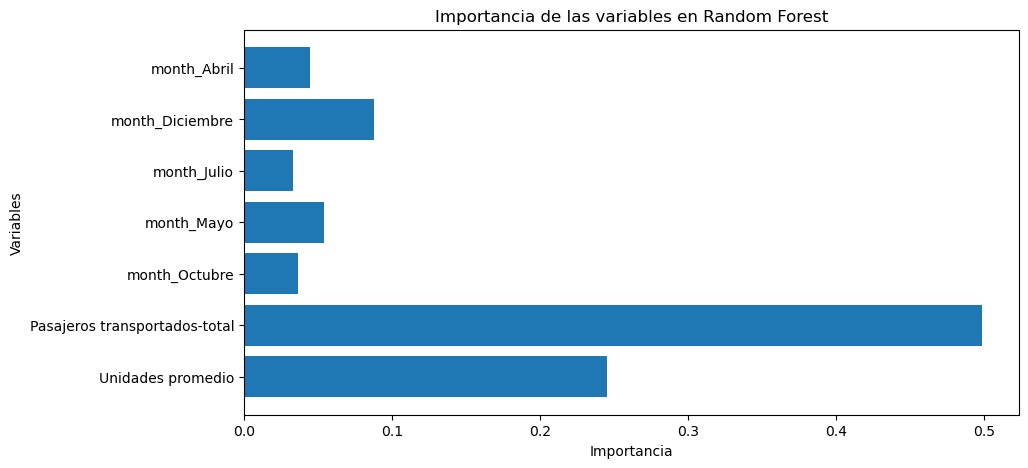

In [38]:
# Obtener importancia de las variables
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Graficar importancia de variables
plt.figure(figsize=(10,5))
plt.barh(feature_names, importances)
plt.xlabel("Importancia")
plt.ylabel("Variables")
plt.title("Importancia de las variables en Random Forest")
plt.show()

**Modelo corregido ideal**

Se elimino el efecto de los meses en base a los estudios anteriores y se conservaron solo las columnas iniciales con valor numerico que podrian influir mas como lo es la cantidad de pasajeros transportados y las unidades enrte semana y en fin de semana. Los resultados se ven fanvorables

In [24]:
Xe2 = ecovia_sin_outliers.drop(columns =['Unidades promedio', 'month', 'year'])
ye2 = ecovia_sin_outliers["Miles de km recorridos"]
# Transformaciones
ye2 = np.log(ye2)  # Raíz cuadrada para suavizar valores altos
Xe2[['Pasajeros transportados-total','Unidades en operacion de L-V',
     'Unidades en operacion de S-D']] = Xe2[['Pasajeros transportados-total','Unidades en operacion de L-V',
     'Unidades en operacion de S-D']].apply(np.log)

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(Xe2, ye2, test_size=0.2, random_state=42)

# Normalización de las variables predictoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar modelo de Regresión Lineal
modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)

# Predicciones
y_pred = modelo.predict(X_test_scaled)

# Evaluar el modelo
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R^2 del modelo de Regresión Lineal: {r2:.4f}")
print(f"RMSE del modelo: {rmse:.4f}")

R^2 del modelo de Regresión Lineal: 0.9954
RMSE del modelo: 0.0069


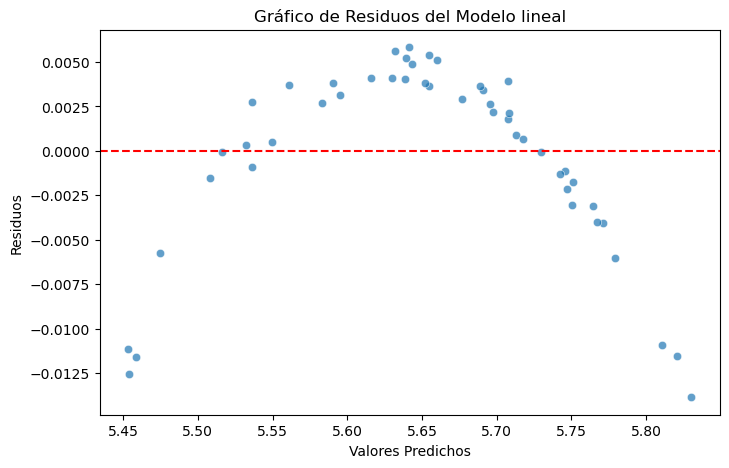

In [25]:
# Obtener predicciones del modelo lineal
Xe2scaled = scaler.transform(Xe2)
 
y_prede = modelo.predict(Xe2scaled)

# Calcular residuos
residuose = ye2 - y_prede

# Gráfico de dispersión de residuos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_prede, y=residuose, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')  # Línea horizontal en 0
plt.xlabel("Valores Predichos")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos del Modelo lineal")
plt.show()

In [26]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Entrenar regresión con los nuevos términos
modelo_poly = LinearRegression()
modelo_poly.fit(X_train_poly, y_train)

# Predicciones y evaluación
y_pred_poly = modelo_poly.predict(X_test_poly)
r2_poly = r2_score(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

print(f"R^2 del modelo polinómico: {r2_poly:.4f}")
print(f"RMSE del modelo polinómico: {rmse_poly:.4f}")

R^2 del modelo polinómico: 1.0000
RMSE del modelo polinómico: 0.0005


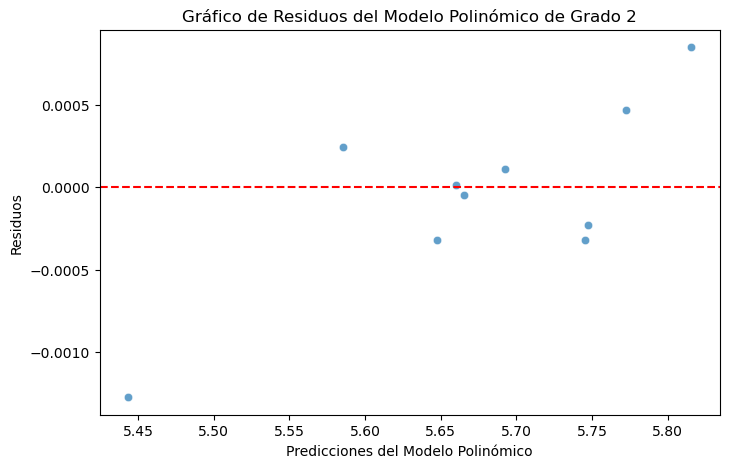

In [27]:
# Cálculo de residuos
residuos = y_test - y_pred_poly

# Gráfico de residuos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_poly, y=residuos, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)  # Línea en y=0
plt.xlabel("Predicciones del Modelo Polinómico")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos del Modelo Polinómico de Grado 2")
plt.show()

In [28]:
mse = mean_squared_error(y_test, y_pred_poly)
rmse=np.sqrt(mse)
print(f"RMSE:{rmse:.4f}")
mae = mean_absolute_error(y_test, y_pred_poly)
print(f"MAE: {mae:.4f}")
mape = (abs(residuos) / abs(y_test)).mean() * 100
print(f"MAPE: {mape:.2f}%")

RMSE:0.0005
MAE: 0.0004
MAPE: 0.01%


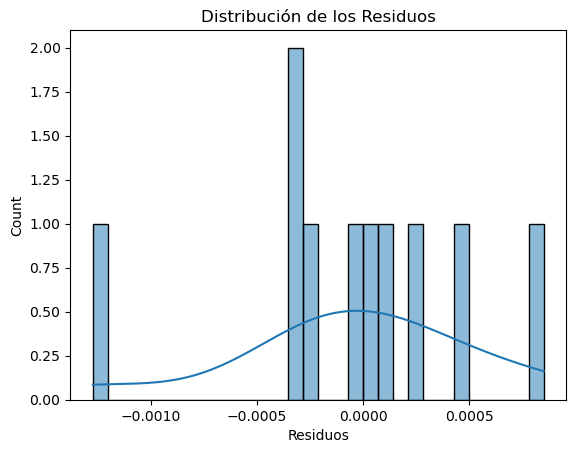

Prueba de normalidad de Shapiro-Wilk: p-value = 0.5536


In [29]:
sns.histplot(residuos, bins=30, kde=True)
plt.xlabel("Residuos")
plt.title("Distribución de los Residuos")
plt.show()

stat, p = stats.shapiro(residuos)
print(f"Prueba de normalidad de Shapiro-Wilk: p-value = {p:.4f}")

In [31]:
cv_scores = cross_val_score(modelo_poly, X_train_poly, y_train, cv=5, scoring="r2")
print(f"R² en validación cruzada: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

R² en validación cruzada: 0.9999 ± 0.0001


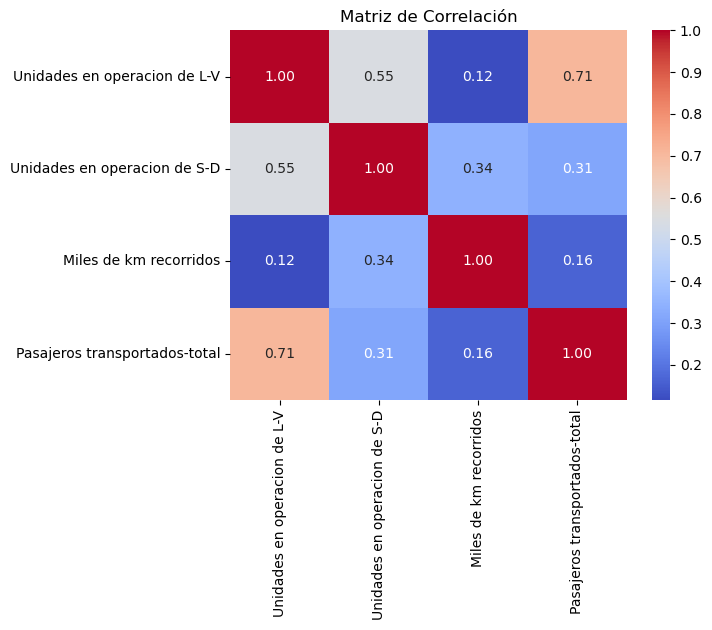

In [33]:
corr_matrix = pd.DataFrame(X_train, columns=X_train.columns).corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

##### Modelo Ecovia: intentos de diseño de modelo

El codigo a continuacion muestra los intentos para el diseño del modelo de ecovia, si bien no muestran los resultados deseables, muestran las aproximaciones que se realizaron y que pueden aplicarse para otros proyectos donde se encuentren molestias similares.

Para incluir la variable 'month' en el modelo de regresion lineal multifactorial, es requerido transformar la variable categorica en una variable numerica o de tipo dummy. Para este caso, se convertiran a variable tipo dummy para no asumir una relacion lineal entre los meses.

In [9]:
# Convertir 'month' en variables dummy
ecovia = pd.get_dummies(ecovia, columns=["month"], drop_first=False)

In [11]:
# Separar variables predictoras y variable objetivo
X = ecovia.drop(columns=["Miles de km recorridos","year"])
y = ecovia["Miles de km recorridos"]

# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Se opto por probar si es requerida la normalizacion por el gran valor de la variable 'pasajeros transportados-total', por lo cual se comparara los resultados y se decidira cual usar en los modelos de los medios de transporte restantes.

In [12]:
# MODELO SIN NORMALIZAR
model_no_scaling = LinearRegression()
model_no_scaling.fit(X_train, y_train)
score_no_scaling = model_no_scaling.score(X_test, y_test)

# Normalización de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MODELO CON NORMALIZACIÓN
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)
score_scaled = model_scaled.score(X_test_scaled, y_test)

# Comparación de coeficientes
coef_no_scaling = pd.Series(model_no_scaling.coef_, index=X.columns)
coef_scaled = pd.Series(model_scaled.coef_, index=X.columns)

# Mostrar resultados
print("\nCoeficientes SIN normalización:\n", coef_no_scaling)
print("\nCoeficientes CON normalización:\n", coef_scaled)

print(f"\nR^2 SIN normalización: {score_no_scaling:.4f}")
print(f"R^2 CON normalización: {score_scaled:.4f}")


Coeficientes SIN normalización:
 Unidades en operacion de L-V     -0.405176
Unidades en operacion de S-D      6.224066
Pasajeros transportados-total     0.000006
month_Abril                       2.751764
month_Agosto                      9.225441
month_Diciembre                  -6.335950
month_Enero                     -19.241575
month_Febrero                   -18.480429
month_Julio                     -10.833746
month_Junio                       0.490200
month_Marzo                      12.369190
month_Mayo                        1.621509
month_Noviembre                  -5.348773
month_Octubre                    33.851832
month_Septiembre                 -0.069463
dtype: float64

Coeficientes CON normalización:
 Unidades en operacion de L-V     -1.415099
Unidades en operacion de S-D     10.581298
Pasajeros transportados-total     1.287975
month_Abril                       0.801195
month_Agosto                      2.681572
month_Diciembre                  -1.612443
month_Enero   

La normalizacion no afecto drasticamente la exactitud del modelo, pero si mejoro la legibilidad de los coeficientes. No obstante, el valor R^2 es negativo, por lo que no tiene mucha funcionalidad el modelo.

In [13]:
# Crear un pipeline con transformación polinomial de grado 2
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Entrenar el modelo con datos normalizados
poly_model.fit(X_train_scaled, y_train)

# Evaluar el modelo
score_poly = poly_model.score(X_test_scaled, y_test)

print(f"R² con regresión polinomial: {score_poly:.4f}")

R² con regresión polinomial: -9.6847


Se intento probar con la transformacion del modelo a escala polinomial, no obstante, el valor obtiene un valor de R^2 incluso menor. Antes de eliminar variables, se analizara la estructura de los datos y se evaluara si al agregar interacciones podria mejorarse el modelo.

**Factor de Inflación de Varianza (VIF)** indica si hay variables redundantes en el modelo. hay un VIF alto (>10), la variable probablemente deba de eliminarse.

In [14]:
# Calcular VIF para cada variable
X_numeric = X[['Unidades en operacion de L-V', 'Unidades en operacion de S-D', 'Pasajeros transportados-total']]
vif_data = pd.DataFrame()
vif_data["Variable"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)

                        Variable         VIF
0   Unidades en operacion de L-V  356.784304
1   Unidades en operacion de S-D  246.948269
2  Pasajeros transportados-total   44.625880


En base a lo anterior podemos ver que las variables de unidades en operacion estan altamente correlacionadas, por lo intentar combinarlas puede reducir la multicolinealidad

In [15]:
ecovia_2 = ecovia
ecovia_2['Unidades promedio'] = (ecovia['Unidades en operacion de L-V'] + ecovia['Unidades en operacion de S-D'])/2

In [16]:
# Separar variables predictoras y variable objetivo
X = ecovia_2.drop(columns=["Unidades en operacion de L-V","Unidades en operacion de S-D", "year", "Miles de km recorridos"])
y = ecovia_2["Miles de km recorridos"]

# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# MODELO SIN NORMALIZAR
model_no_scaling = LinearRegression()
model_no_scaling.fit(X_train, y_train)
score_no_scaling = model_no_scaling.score(X_test, y_test)

coef_no_scaling = pd.Series(model_no_scaling.coef_, index=X.columns)
print("\nCoeficientes SIN normalización:\n", coef_no_scaling)
print(f"\nR^2 SIN normalización: {score_no_scaling:.4f}")


Coeficientes SIN normalización:
 Pasajeros transportados-total    -0.000012
month_Abril                      -0.432290
month_Agosto                      7.747040
month_Diciembre                  -1.189600
month_Enero                     -25.024605
month_Febrero                   -20.851746
month_Julio                      -8.958501
month_Junio                      -0.316206
month_Marzo                      10.235762
month_Mayo                        6.662898
month_Noviembre                  -2.481829
month_Octubre                    35.447764
month_Septiembre                 -0.838688
Unidades promedio                 4.277529
dtype: float64

R^2 SIN normalización: -1.4721


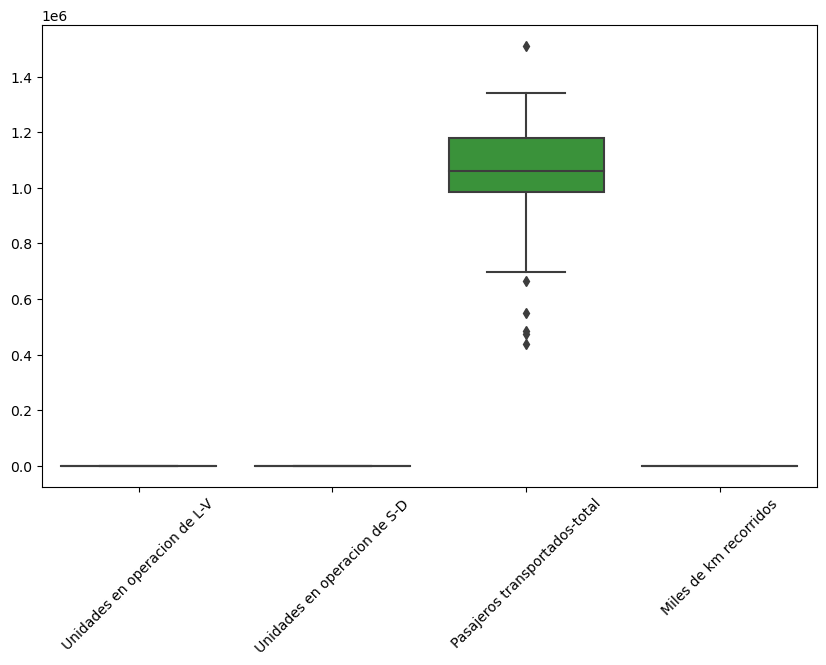

In [18]:
# Boxplot para detectar outliers en las variables más importantes
plt.figure(figsize=(10, 6))
sns.boxplot(data=ecovia[["Unidades en operacion de L-V", "Unidades en operacion de S-D", "Pasajeros transportados-total", "Miles de km recorridos"]])
plt.xticks(rotation=45)
plt.show()

Existen outliers en los 'Pasajeros tranportados-total', por lo que seria ideal eliminarlos ya que pueden causar ruido.

In [19]:
# Suponiendo que tu DataFrame se llama df y la columna de interés es 'Pasajeros transportados'
Q1 = ecovia['Pasajeros transportados-total'].quantile(0.25)
Q3 = ecovia['Pasajeros transportados-total'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites inferior y superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar los valores dentro de los límites
ecovia_sin_outliers = ecovia[(ecovia['Pasajeros transportados-total'] >= limite_inferior) & (ecovia['Pasajeros transportados-total'] <= limite_superior)]

In [20]:
# Separar variables predictoras y variable objetivo
X = ecovia_sin_outliers.drop(columns=["Miles de km recorridos","year","Unidades en operacion de L-V","Unidades en operacion de S-D"])
y = ecovia_sin_outliers["Miles de km recorridos"]

# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MODELO SIN NORMALIZAR
model_no_scaling = LinearRegression()
model_no_scaling.fit(X_train, y_train)
score_no_scaling = model_no_scaling.score(X_test, y_test)

# Normalización de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MODELO CON NORMALIZACIÓN
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)
score_scaled = model_scaled.score(X_test_scaled, y_test)

# Comparación de coeficientes
coef_no_scaling = pd.Series(model_no_scaling.coef_, index=X.columns)
coef_scaled = pd.Series(model_scaled.coef_, index=X.columns)

# Mostrar resultados
print("\nCoeficientes SIN normalización:\n", coef_no_scaling)
print("\nCoeficientes CON normalización:\n", coef_scaled)

print(f"\nR^2 SIN normalización: {score_no_scaling:.4f}")
print(f"R^2 CON normalización: {score_scaled:.4f}")


Coeficientes SIN normalización:
 Pasajeros transportados-total     0.000020
month_Abril                      -0.422519
month_Agosto                     -8.184720
month_Diciembre                   5.265552
month_Enero                      -2.055896
month_Febrero                   -13.686143
month_Julio                     -21.200285
month_Junio                      -6.864148
month_Marzo                      14.546666
month_Mayo                       13.977917
month_Noviembre                   3.361189
month_Octubre                    11.141089
month_Septiembre                  4.121299
Unidades promedio                 1.451779
dtype: float64

Coeficientes CON normalización:
 Pasajeros transportados-total    2.913388
month_Abril                     -0.262023
month_Agosto                    -2.355152
month_Diciembre                  1.271802
month_Enero                     -0.702474
month_Febrero                   -4.368708
month_Julio                     -4.856586
month_Junio          

**Cambio de variable dummy month a variable numerica:** Las variables dummy pueden llegar a generar multicolinealidad por lo cambiar a numerica pede ser conveniente para la funcionalidad del modelo.

In [21]:
meses = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

# Obtener el número del mes basado en las columnas dummy
ecovia_sin_outliers["month"] = np.argmax(ecovia_sin_outliers[["month_" + m for m in meses]].values, axis=1) + 1

# Eliminar las columnas dummy del mes
ecovia_sin_outliers = ecovia_sin_outliers.drop(columns=["month_" + m for m in meses])

In [43]:
preevia= ecovia_sin_outliers[['Miles de km recorridos', 'Unidades en operacion de L-V', 'Unidades en operacion de S-D',
                              'month', 'Pasajeros transportados-total']].reset_index(drop=True)

In [44]:
# Separar variables predictoras y variable objetivo
X = preevia.drop(columns=["Miles de km recorridos"])
y = preevia["Miles de km recorridos"]

# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo con la nueva variable month numérica
model = LinearRegression()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

print(f"\nR^2 CON variable numérica para el mes: {score:.4f}")


R^2 CON variable numérica para el mes: -0.1175


In [45]:
# MODELO SIN NORMALIZAR
model_no_scaling = LinearRegression()
model_no_scaling.fit(X_train, y_train)
score_no_scaling = model_no_scaling.score(X_test, y_test)

# Normalización de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MODELO CON NORMALIZACIÓN
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)
score_scaled = model_scaled.score(X_test_scaled, y_test)

# Comparación de coeficientes
coef_no_scaling = pd.Series(model_no_scaling.coef_, index=X.columns)
coef_scaled = pd.Series(model_scaled.coef_, index=X.columns)

# Mostrar resultados
print("\nCoeficientes SIN normalización:\n", coef_no_scaling)
print("\nCoeficientes CON normalización:\n", coef_scaled)

print(f"\nR^2 SIN normalización: {score_no_scaling:.4f}")
print(f"R^2 CON normalización: {score_scaled:.4f}")


Coeficientes SIN normalización:
 Unidades en operacion de L-V    -2.813830
Unidades en operacion de S-D     6.854396
month                           -0.036688
Pasajeros transportados-total    0.000050
dtype: float64

Coeficientes CON normalización:
 Unidades en operacion de L-V     -8.653502
Unidades en operacion de S-D     11.824104
month                            -0.130565
Pasajeros transportados-total     7.404529
dtype: float64

R^2 SIN normalización: -0.1175
R^2 CON normalización: -0.1175


In [46]:
# Crear un pipeline con transformación polinomial de grado 2
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Entrenar el modelo con datos normalizados
poly_model.fit(X_train_scaled, y_train)

# Evaluar el modelo
score_poly = poly_model.score(X_test_scaled, y_test)


# Obtener los nombres de las características transformadas
feature_names = poly_model.named_steps['polynomialfeatures'].get_feature_names_out(X_train.columns)

# Obtener los coeficientes del modelo lineal después de la transformación polinomial
coeficientes = poly_model.named_steps['linearregression'].coef_

# Imprimir los coeficientes junto con los nombres de las características
coef_df = pd.DataFrame({'Feature': feature_names, 'Coeficiente': coeficientes})
print(coef_df)
print(f"R² con regresión polinomial: {score_poly:.4f}")

                                              Feature  Coeficiente
0                                                   1     0.000000
1                        Unidades en operacion de L-V   -11.220326
2                        Unidades en operacion de S-D    18.963170
3                                               month    -1.151754
4                       Pasajeros transportados-total    11.159034
5                      Unidades en operacion de L-V^2     3.425809
6   Unidades en operacion de L-V Unidades en opera...    18.644530
7                  Unidades en operacion de L-V month    14.963884
8   Unidades en operacion de L-V Pasajeros transpo...   -30.263547
9                      Unidades en operacion de S-D^2    -5.800168
10                 Unidades en operacion de S-D month     7.233390
11  Unidades en operacion de S-D Pasajeros transpo...     4.045103
12                                            month^2     4.507619
13                month Pasajeros transportados-total   -16.82

### Modelo transmetro

In [4]:
corr = transmetro.drop(['month', 'year'], axis=1).corr()['Miles de km recorridos'].sort_values()
corr

Pasajeros transportados-total    0.882912
Personal ocupado                 0.972663
Numero de rutas                  0.974329
Unidades en operacion de S-D     0.990271
Unidades en operacion de L-V     0.993012
Miles de km recorridos           1.000000
Name: Miles de km recorridos, dtype: float64

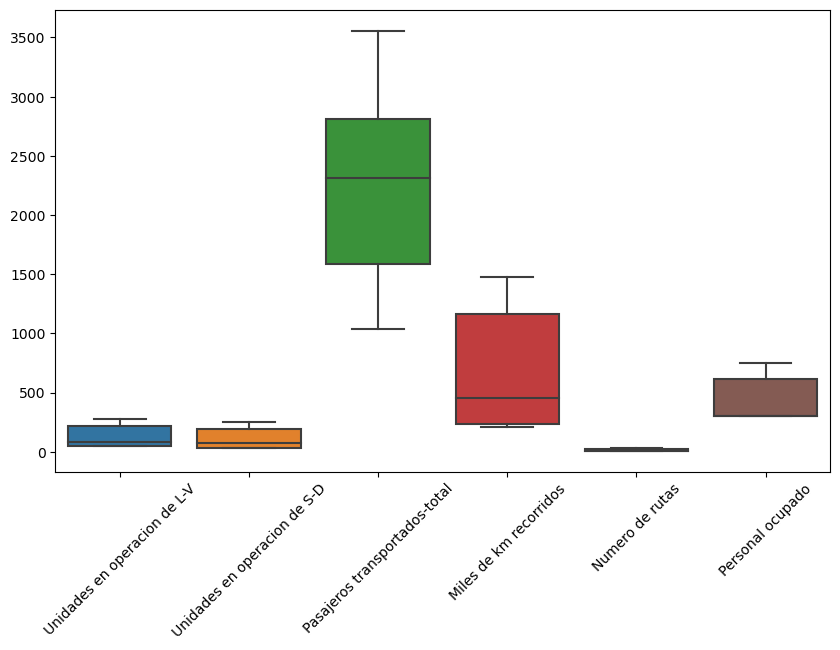

In [5]:
# Boxplot para detectar outliers en las variables más importantes
plt.figure(figsize=(10, 6))
sns.boxplot(data=transmetro[["Unidades en operacion de L-V", "Unidades en operacion de S-D", "Pasajeros transportados-total", "Miles de km recorridos",
                        'Numero de rutas', 'Personal ocupado']])
plt.xticks(rotation=45)
plt.show()

Ninguna de las variables presenta outliers, lo cual indica que podemos proceder sin requerir alguna eliminacion de datos.

###### Intento de modelo (cosas que no hacer)

Para el modelo de transmetro, el modelo de regresion lineal simple cumple con buen valor de R^2, no obstante, al evaluar los residuos, se muestran inconvenientes de heterocedasticidad. Se requiere modificar el acercamiento.

In [44]:
#cambiar la columna month
# Diccionario de mapeo de meses en español a números
meses_a_numeros = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4, "Mayo": 5, "Junio": 6,
    "Julio": 7, "Agosto": 8, "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

# Reemplazar los nombres de los meses por su número
transmetro["month_num"] = transmetro["month"].map(meses_a_numeros)

# Eliminar la columna original
transmetro.drop(columns=["month"], inplace=True)
transmetro.head(2)

,Unidades en operacion de L-V,Unidades en operacion de S-D,Miles de km recorridos,Pasajeros transportados-total,year,Numero de rutas,Personal ocupado,month_num
0,86.0,63.0,467.9,2921.9,2020,10.0,299.0,1
1,86.0,63.0,437.4,2817.7,2020,10.0,299.0,2


In [45]:
# Separar variables predictoras y variable objetivo
Xt = transmetro.drop(columns=["Miles de km recorridos"])
yt = transmetro["Miles de km recorridos"]

# División de datos en entrenamiento y prueba
X_traint, X_testt, y_traint, y_testt = train_test_split(Xt, yt, test_size=0.2, random_state=42)

In [48]:
# MODELO SIN NORMALIZAR
model_no_scalingt = LinearRegression()
model_no_scalingt.fit(X_traint, y_traint)
score_no_scalingt = model_no_scalingt.score(X_testt, y_testt)

# Normalización de los datos
scaler = StandardScaler()
X_train_scaledt = scaler.fit_transform(X_traint)
X_test_scaledt = scaler.transform(X_testt)

# MODELO CON NORMALIZACIÓN
model_scaledt = LinearRegression()
model_scaledt.fit(X_train_scaledt, y_traint)
score_scaledt = model_scaledt.score(X_test_scaledt, y_testt)

# Comparación de coeficientes
coef_no_scalingt = pd.Series(model_no_scalingt.coef_, index=Xt.columns)
coef_scaledt = pd.Series(model_scaledt.coef_, index=Xt.columns)

# Mostrar resultados
print("\nCoeficientes SIN normalización:\n", coef_no_scalingt)
print("\nCoeficientes CON normalización:\n", coef_scaledt)

print(f"\nR^2 SIN normalización: {score_no_scalingt:.4f}")
print(f"R^2 CON normalización: {score_scaledt:.4f}")


Coeficientes SIN normalización:
 Unidades en operacion de L-V      3.513746
Unidades en operacion de S-D     -0.393768
Pasajeros transportados-total     0.092325
year                             21.118393
Numero de rutas                   8.482238
Personal ocupado                  0.139188
month_num                         1.357361
dtype: float64

Coeficientes CON normalización:
 Unidades en operacion de L-V     296.015783
Unidades en operacion de S-D     -30.305279
Pasajeros transportados-total     60.274355
year                              29.010332
Numero de rutas                   75.985667
Personal ocupado                  23.411286
month_num                          4.263450
dtype: float64

R^2 SIN normalización: 0.9952
R^2 CON normalización: 0.9952


In [60]:
# Crear un pipeline con transformación polinomial de grado 2
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Entrenar el modelo con datos normalizados
poly_model.fit(X_train_scaled, y_train)

# Evaluar el modelo
score_poly = poly_model.score(X_test_scaled, y_test)


# Obtener los nombres de las características transformadas
feature_names = poly_model.named_steps['polynomialfeatures'].get_feature_names_out(X_train.columns)

# Obtener los coeficientes del modelo lineal después de la transformación polinomial
coeficientes = poly_model.named_steps['linearregression'].coef_

# Imprimir los coeficientes junto con los nombres de las características
coef_df = pd.DataFrame({'Feature': feature_names, 'Coeficiente': coeficientes})
print(coef_df)
print(f"R² con regresión polinomial: {score_poly:.4f}")

                                              Feature   Coeficiente
0                                                   1 -1.427175e+15
1                        Unidades en operacion de L-V -3.092252e+02
2                        Unidades en operacion de S-D  2.537543e+02
3                       Pasajeros transportados-total  1.416123e+02
4                                     Numero de rutas  8.978374e+01
5                                    Personal ocupado  3.204115e+02
6                                           month_num  1.645289e+01
7                      Unidades en operacion de L-V^2 -6.431572e+02
8   Unidades en operacion de L-V Unidades en opera...  4.484540e+03
9   Unidades en operacion de L-V Pasajeros transpo... -1.794139e+03
10       Unidades en operacion de L-V Numero de rutas -9.312459e+02
11      Unidades en operacion de L-V Personal ocupado -1.316620e+03
12             Unidades en operacion de L-V month_num -1.020986e+01
13                     Unidades en operacion de 

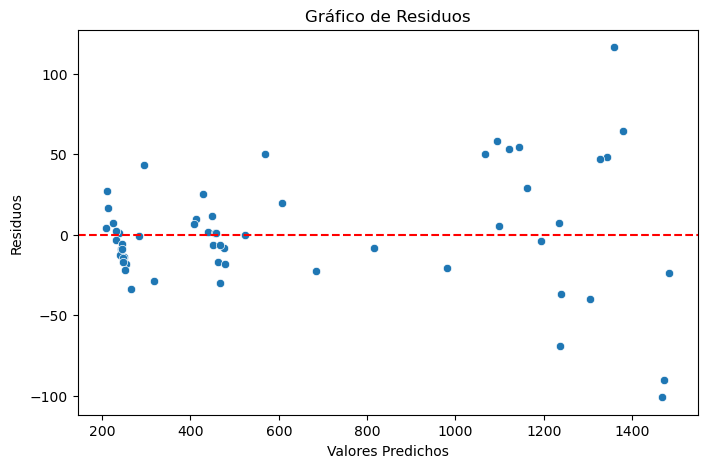

In [49]:
df_transmetro= pd.DataFrame()
df_transmetro['y_pred'] = model_no_scalingt.predict(Xt)
df_transmetro['residuals'] = yt - df_transmetro['y_pred']

# Graficar los residuos vs. valores predichos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_transmetro['y_pred'], y=df_transmetro['residuals'])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.show()

###### Acercamiento modelo transmetro ( Modelo mas apto )

**NOTA:** Para el modelo mas apto es requerido crear las variables dummy de la columna month que se encuentra en la siguiente celda

In [6]:
# Convertir 'month' en variables dummy
transmetro = pd.get_dummies(transmetro, columns=["month"], drop_first=False)

In [8]:
# Separar variables predictoras y variable objetivo
Xt = transmetro.drop(columns=["Miles de km recorridos", 'year'])
yt = transmetro["Miles de km recorridos"]

# División de datos en entrenamiento y prueba
X_traint, X_testt, y_traint, y_testt = train_test_split(Xt, yt, test_size=0.2, random_state=42)

# MODELO SIN NORMALIZAR
model_no_scalingt = LinearRegression()
model_no_scalingt.fit(X_traint, y_traint)
score_no_scalingt = model_no_scalingt.score(X_testt, y_testt)

# Normalización de los datos
scaler = StandardScaler()
X_train_scaledt = scaler.fit_transform(X_traint)
X_test_scaledt = scaler.transform(X_testt)

# MODELO CON NORMALIZACIÓN
model_scaledt = LinearRegression()
model_scaledt.fit(X_train_scaledt, y_traint)
score_scaledt = model_scaledt.score(X_test_scaledt, y_testt)

# Comparación de coeficientes
coef_no_scalingt = pd.Series(model_no_scalingt.coef_, index=Xt.columns)
coef_scaledt = pd.Series(model_scaledt.coef_, index=Xt.columns)

# Mostrar resultados
print("\nCoeficientes SIN normalización:\n", coef_no_scalingt)
print("\nCoeficientes CON normalización:\n", coef_scaledt)

print(f"\nR^2 SIN normalización: {score_no_scalingt:.4f}")
print(f"R^2 CON normalización: {score_scaledt:.4f}")


Coeficientes SIN normalización:
 Unidades en operacion de L-V      2.433962
Unidades en operacion de S-D      0.473199
Pasajeros transportados-total     0.142002
Numero de rutas                  13.566126
Personal ocupado                  0.009698
month_Abril                      13.707951
month_Agosto                      7.466359
month_Diciembre                  33.882325
month_Enero                      25.544888
month_Febrero                   -94.714183
month_Julio                      29.481705
month_Junio                      25.468427
month_Marzo                      -8.988183
month_Mayo                       13.706848
month_Noviembre                  -0.289496
month_Octubre                   -22.882757
month_Septiembre                -22.383883
dtype: float64

Coeficientes CON normalización:
 Unidades en operacion de L-V     205.049301
Unidades en operacion de S-D      36.418463
Pasajeros transportados-total     92.706737
Numero de rutas                  121.528210
Personal o

In [9]:
# Crear un pipeline con transformación polinomial de grado 2
poly_modelt = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Entrenar el modelo con datos normalizados
poly_modelt.fit(X_train_scaledt, y_traint)

# Evaluar el modelo
score_polyt = poly_modelt.score(X_test_scaledt, y_testt)


# Obtener los nombres de las características transformadas
feature_namest = poly_modelt.named_steps['polynomialfeatures'].get_feature_names_out(X_traint.columns)

# Obtener los coeficientes del modelo lineal después de la transformación polinomial
coeficientest = poly_modelt.named_steps['linearregression'].coef_

# Imprimir los coeficientes junto con los nombres de las características
coef_dft = pd.DataFrame({'Feature': feature_namest, 'Coeficiente': coeficientest})
print(coef_dft)
print(f"R² con regresión polinomial: {score_polyt:.4f}")

                              Feature  Coeficiente
0                                   1     4.958269
1        Unidades en operacion de L-V   108.931741
2        Unidades en operacion de S-D    79.008037
3       Pasajeros transportados-total    70.462206
4                     Numero de rutas   104.171371
..                                ...          ...
166     month_Noviembre month_Octubre     0.294139
167  month_Noviembre month_Septiembre     0.700822
168                   month_Octubre^2     0.516399
169    month_Octubre month_Septiembre    -0.439021
170                month_Septiembre^2     0.010006

[171 rows x 2 columns]
R² con regresión polinomial: 0.6656


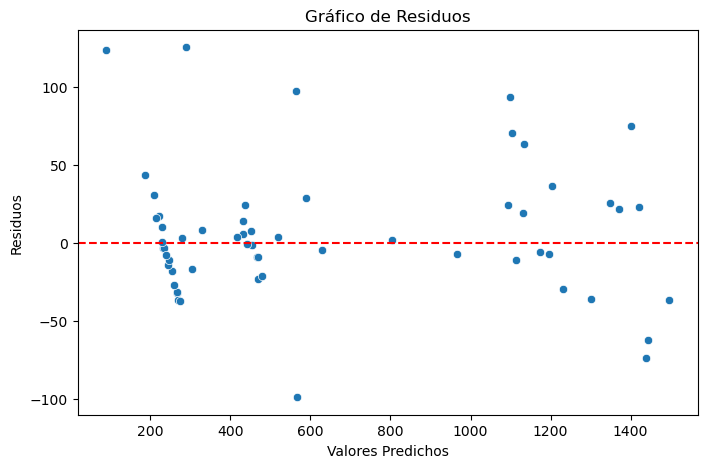

In [10]:
df_transmetro= pd.DataFrame()
df_transmetro['y_pred'] = model_no_scalingt.predict(Xt)
df_transmetro['residuals'] = yt - df_transmetro['y_pred']

# Graficar los residuos vs. valores predichos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_transmetro['y_pred'], y=df_transmetro['residuals'])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.show()

**Modelo mas apto encontrado para dataset transmetro:**

Transformar las variables dependientes e independientes puede ayudar a predecir a mejorar la dispersion de los datos y la heterocedasticidad, por lo que a continuacion se implementa

In [138]:
# Separar variables predictoras y variable objetivo
Xt = transmetro.drop(columns=["Miles de km recorridos", 'year'])
yt = transmetro["Miles de km recorridos"]

#Relacion puede ser no lineal sino logaritmica en base a la forma
yt = np.log(yt)

#Los valores predichos altos estan mas dispersos, considerando que la variable pasajeros 
# total de igual manera tiene magnitud grande, suavizar los valores podria ayudar.
Xt[['Pasajeros transportados-total', 'Unidades en operacion de L-V',
   'Unidades en operacion de S-D', 'Numero de rutas', 'Personal ocupado']] = Xt[['Pasajeros transportados-total', 'Unidades en operacion de L-V',
   'Unidades en operacion de S-D', 'Numero de rutas', 'Personal ocupado']].apply(np.sqrt)

# División de datos en entrenamiento y prueba
X_traint, X_testt, y_traint, y_testt = train_test_split(Xt, yt, test_size=0.2, random_state=42)

# MODELO SIN NORMALIZAR
model_no_scalingt = LinearRegression()
model_no_scalingt.fit(X_traint, y_traint)
score_no_scalingt = model_no_scalingt.score(X_testt, y_testt)

# Normalización de los datos
scaler = StandardScaler()
X_train_scaledt = scaler.fit_transform(X_traint)
X_test_scaledt = scaler.transform(X_testt)

# MODELO CON NORMALIZACIÓN
model_scaledt = LinearRegression()
model_scaledt.fit(X_train_scaledt, y_traint)
score_scaledt = model_scaledt.score(X_test_scaledt, y_testt)

# Comparación de coeficientes
coef_no_scalingt = pd.Series(model_no_scalingt.coef_, index=Xt.columns)
coef_scaledt = pd.Series(model_scaledt.coef_, index=Xt.columns)

# Mostrar resultados
print("\nCoeficientes SIN normalización:\n", coef_no_scalingt)
print("\nCoeficientes CON normalización:\n", coef_scaledt)

print(f"\nR^2 SIN normalización: {score_no_scalingt:.4f}")
print(f"R^2 CON normalización: {score_scaledt:.4f}")


Coeficientes SIN normalización:
 Unidades en operacion de L-V     0.048129
Unidades en operacion de S-D     0.112545
Pasajeros transportados-total    0.028508
Numero de rutas                 -0.021329
Personal ocupado                -0.014423
month_Abril                      0.018897
month_Agosto                    -0.039917
month_Diciembre                  0.123610
month_Enero                      0.063460
month_Febrero                   -0.117551
month_Julio                     -0.015060
month_Junio                      0.024714
month_Marzo                      0.012564
month_Mayo                       0.027237
month_Noviembre                  0.020514
month_Octubre                   -0.066394
month_Septiembre                -0.052073
dtype: float64

Coeficientes CON normalización:
 Unidades en operacion de L-V     0.177114
Unidades en operacion de S-D     0.414729
Pasajeros transportados-total    0.198086
Numero de rutas                 -0.022067
Personal ocupado                -0.

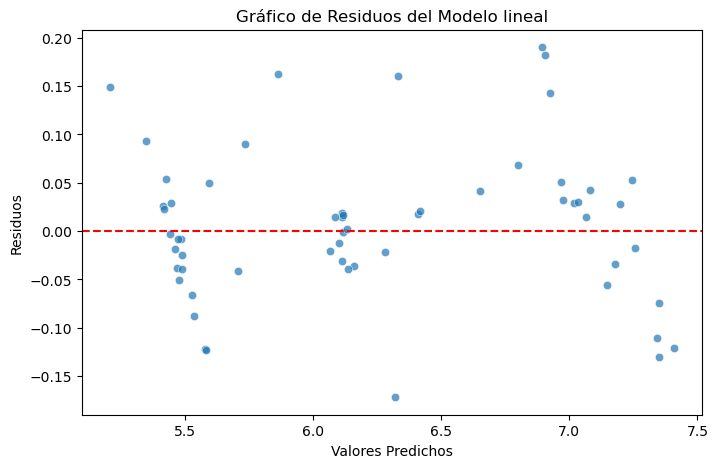

In [159]:
# Obtener predicciones del modelo lineal
y_predtn = model_no_scalingt.predict(Xt)

# Calcular residuos
residuostn = yt - y_predtn

# Gráfico de dispersión de residuos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_predtn, y=residuostn, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')  # Línea horizontal en 0
plt.xlabel("Valores Predichos")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos del Modelo lineal")
plt.show()

In [161]:
mse = mean_squared_error(yt, y_predtn)
rmse=np.sqrt(mse)
print(f"RMSE:{rmse:.4f}")
mae = mean_absolute_error(yt, y_predtn)
print(f"MAE: {mae:.4f}")
mape = (abs(residuostn) / abs(yt)).mean() * 100
print(f"MAPE: {mape:.2f}%")

RMSE:0.0773
MAE: 0.0578
MAPE: 0.92%


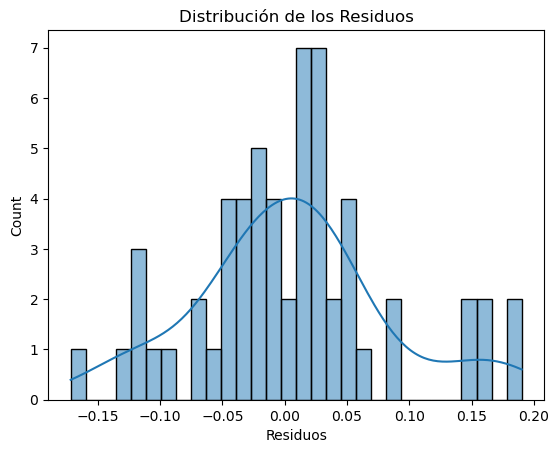

Prueba de normalidad de Shapiro-Wilk: p-value = 0.0829


In [162]:
sns.histplot(residuostn, bins=30, kde=True)
plt.xlabel("Residuos")
plt.title("Distribución de los Residuos")
plt.show()

stat, pn = stats.shapiro(residuostn)
print(f"Prueba de normalidad de Shapiro-Wilk: p-value = {pn:.4f}")

In [163]:
cv_scoresn = cross_val_score(model_no_scalingt, X_traint, y_traint, cv=5, scoring="r2")
print(f"R² en validación cruzada: {cv_scoresn.mean():.4f} ± {cv_scoresn.std():.4f}")

R² en validación cruzada: 0.9788 ± 0.0115


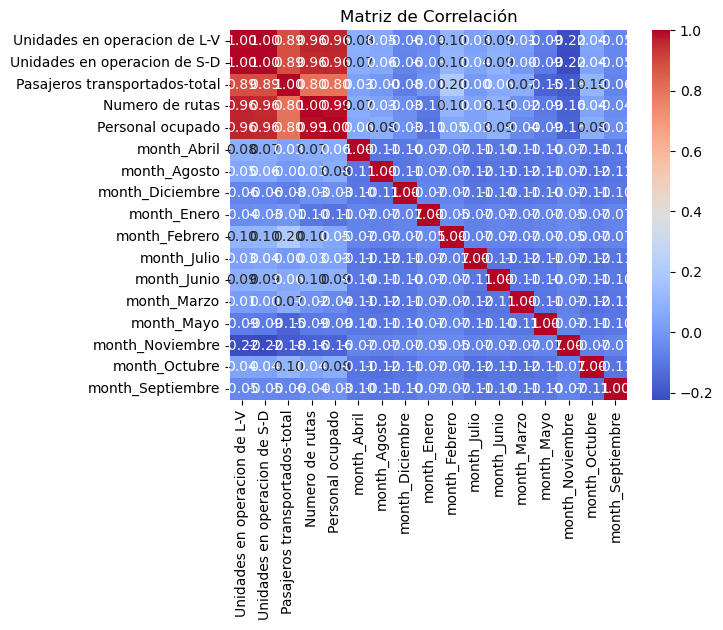

In [164]:
corr_matrix = pd.DataFrame(X_traint, columns=X_traint.columns).corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

*Modelo polinomial (Muestra overfitting)*

In [25]:
# Crear un pipeline con transformación polinomial de grado 3
poly_modelt = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())

# Entrenar el modelo con datos normalizados
poly_modelt.fit(X_train_scaledt, y_traint)

# Evaluar el modelo
score_polyt = poly_modelt.score(X_test_scaledt, y_testt)


# Obtener los nombres de las características transformadas
feature_namest = poly_modelt.named_steps['polynomialfeatures'].get_feature_names_out(X_traint.columns)

# Obtener los coeficientes del modelo lineal después de la transformación polinomial
coeficientest = poly_modelt.named_steps['linearregression'].coef_

# Imprimir los coeficientes junto con los nombres de las características
coef_dft = pd.DataFrame({'Feature': feature_namest, 'Coeficiente': coeficientest})
print(coef_dft)
print(f"R² con regresión polinomial: {score_polyt:.4f}")

                                 Feature  Coeficiente
0                                      1    -0.003583
1           Unidades en operacion de L-V     0.009334
2           Unidades en operacion de S-D     0.014584
3          Pasajeros transportados-total     0.012745
4                        Numero de rutas     0.002884
...                                  ...          ...
1135  month_Noviembre month_Septiembre^2     0.000288
1136                     month_Octubre^3     0.004090
1137    month_Octubre^2 month_Septiembre    -0.000929
1138    month_Octubre month_Septiembre^2     0.000062
1139                  month_Septiembre^3    -0.000922

[1140 rows x 2 columns]
R² con regresión polinomial: 0.8778


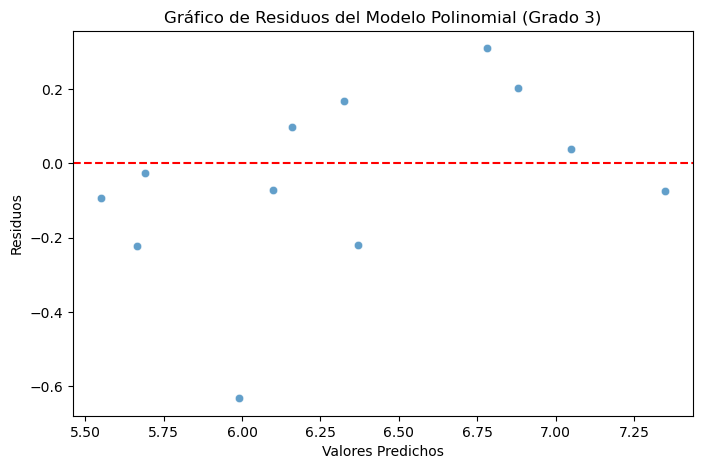

In [38]:
# Obtener predicciones del modelo polinomial
y_predt = poly_modelt.predict(X_test_scaledt)

# Calcular residuos
residuost = y_testt - y_predt

# Gráfico de dispersión de residuos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_predt, y=residuost, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')  # Línea horizontal en 0
plt.xlabel("Valores Predichos")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos del Modelo Polinomial (Grado 3)")
plt.show()

In [55]:
mse = mean_squared_error(y_testt, y_predt)
rmse=np.sqrt(mse)
print(f"RMSE:{rmse:.4f}")
mae = mean_absolute_error(y_testt, y_predt)
print(f"MAE: {mae:.4f}")
mape = (abs(residuost) / abs(y_testt)).mean() * 100
print(f"MAPE: {mape:.2f}%")

RMSE:0.2405
MAE: 0.1795
MAPE: 2.98%


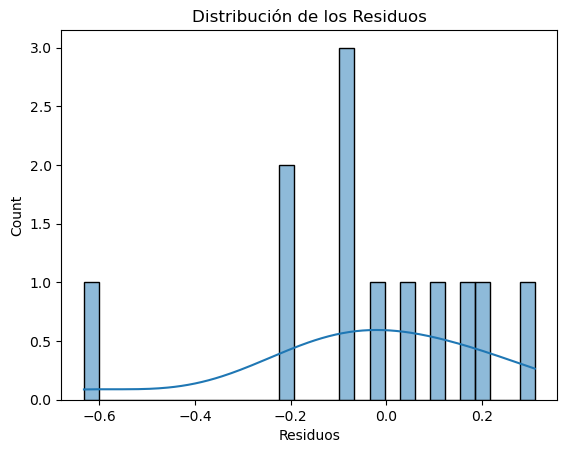

Prueba de normalidad de Shapiro-Wilk: p-value = 0.3795


In [57]:
sns.histplot(residuost, bins=30, kde=True)
plt.xlabel("Residuos")
plt.title("Distribución de los Residuos")
plt.show()

stat, p = stats.shapiro(residuost)
print(f"Prueba de normalidad de Shapiro-Wilk: p-value = {p:.4f}")

In [58]:
cv_scores = cross_val_score(poly_modelt, X_train_scaledt, y_traint, cv=5, scoring="r2")
print(f"R² en validación cruzada: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

R² en validación cruzada: 0.6949 ± 0.1374


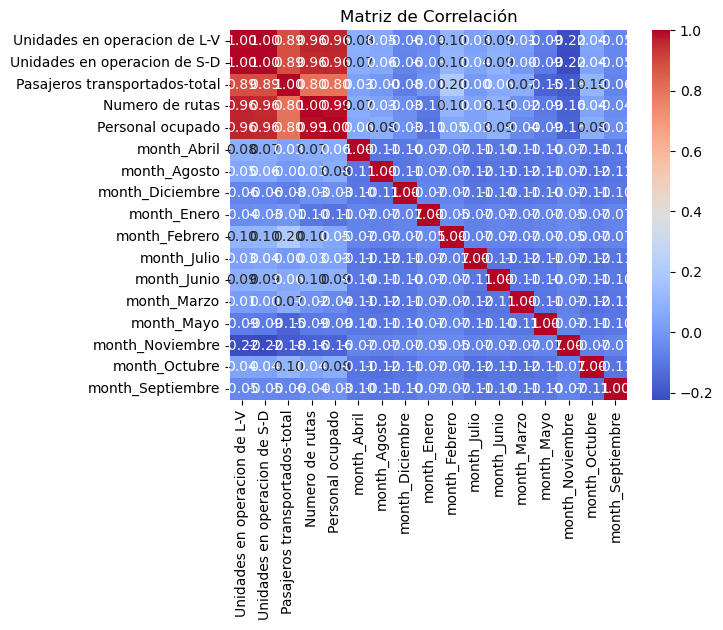

In [59]:
corr_matrix = pd.DataFrame(X_train_scaledt, columns=X_traint.columns).corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

###### Acercamiento a mejorar modelo transmetro (No presenta mejoria)

En busca de mejorar la posible colinealidad entre las variables con alta correlacion. Se propuso remover algunas variables con la finalidad de reducir el posible overfit, ademas de implementar un modelo ridge para penalizar los coeficientes. No obstante, se observo un mejor desempeño predictivo en términos de error para el modelo lineal al evaluar metricas(R^2,RMSE,MAE).

Ademas, no se observa gran cambio en la reduccion de la correlacion entre las variables, por lo que su inclusion resulta redundante.

In [69]:
transmetro_2= transmetro.drop(columns=['year', 'Personal ocupado'])
transmetro_2['Unidades promedio']= (transmetro_2['Unidades en operacion de L-V']+transmetro_2['Unidades en operacion de S-D'])/2
transmetro_2.drop(columns= ['Unidades en operacion de L-V','Unidades en operacion de S-D'], inplace= True)

In [123]:
# Separar variables predictoras y variable objetivo
Xt = transmetro_2.drop(columns=["Miles de km recorridos", 'Numero de rutas'])
yt = transmetro_2["Miles de km recorridos"]

# Relación puede ser no lineal sino logarítmica en base a la forma
yt = np.log(yt)

# Los valores predichos altos están más dispersos, considerando que la variable pasajeros 
# total de igual manera tiene magnitud grande, suavizar los valores podría ayudar.
Xt[['Pasajeros transportados-total', 'Unidades promedio']] = Xt[['Pasajeros transportados-total',
                                                                 'Unidades promedio']].apply(np.sqrt)

# División de datos en entrenamiento y prueba
X_traint, X_testt, y_traint, y_testt = train_test_split(Xt, yt, test_size=0.2, random_state=42)

# MODELO SIN NORMALIZAR (puedes comparar con Ridge)
ridge_no_scalingt = Ridge(alpha=1.0)  # Usando Ridge con alpha = 1.0
ridge_no_scalingt.fit(X_traint, y_traint)
score_no_scalingt = ridge_no_scalingt.score(X_testt, y_testt)

# Normalización de los datos
scaler = StandardScaler()
X_train_scaledt = scaler.fit_transform(X_traint)
X_test_scaledt = scaler.transform(X_testt)

# MODELO CON NORMALIZACIÓN (Ridge con normalización)
ridge_scaledt = Ridge(alpha=1.0)  # Usando Ridge con alpha = 1.0
ridge_scaledt.fit(X_train_scaledt, y_traint)
score_scaledt = ridge_scaledt.score(X_test_scaledt, y_testt)

# Comparación de coeficientes
coef_no_scalingt = pd.Series(ridge_no_scalingt.coef_, index=Xt.columns)
coef_scaledt = pd.Series(ridge_scaledt.coef_, index=Xt.columns)

# Mostrar resultados
print("\nCoeficientes SIN normalización (Ridge):\n", coef_no_scalingt)
print("\nCoeficientes CON normalización (Ridge):\n", coef_scaledt)

print(f"\nR^2 SIN normalización (Ridge): {score_no_scalingt:.4f}")
print(f"R^2 CON normalización (Ridge): {score_scaledt:.4f}")


Coeficientes SIN normalización (Ridge):
 Pasajeros transportados-total    0.030766
month_Abril                      0.017599
month_Agosto                    -0.031845
month_Diciembre                  0.091444
month_Enero                      0.064384
month_Febrero                   -0.072932
month_Julio                     -0.007930
month_Junio                      0.021424
month_Marzo                      0.012864
month_Mayo                       0.023036
month_Noviembre                 -0.006201
month_Octubre                   -0.065337
month_Septiembre                -0.046507
Unidades promedio                0.135714
dtype: float64

Coeficientes CON normalización (Ridge):
 Pasajeros transportados-total    0.237625
month_Abril                      0.007796
month_Agosto                    -0.009891
month_Diciembre                  0.032068
month_Enero                      0.018771
month_Febrero                   -0.023295
month_Julio                     -0.001716
month_Junio        

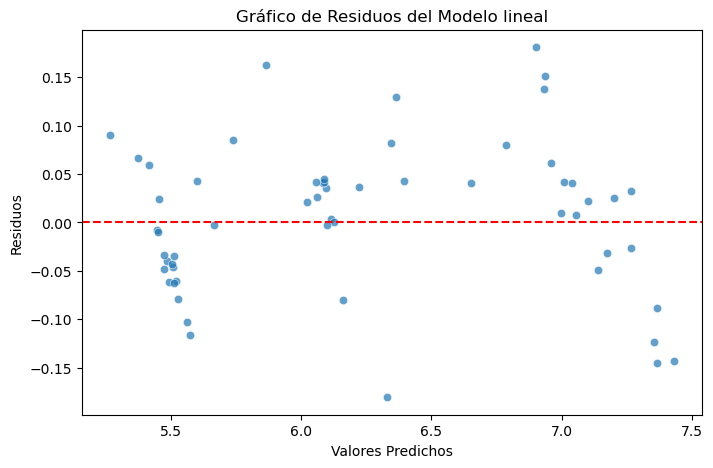

In [114]:
# Obtener predicciones del modelo polinomial
y_predtn = ridge_no_scalingt.predict(Xt)

# Calcular residuos
residuostn = yt - y_predtn

# Gráfico de dispersión de residuos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_predtn, y=residuostn, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')  # Línea horizontal en 0
plt.xlabel("Valores Predichos")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos del Modelo lineal")
plt.show()

In [115]:
mse = mean_squared_error(yt, y_predtn)
rmse=np.sqrt(mse)
print(f"RMSE:{rmse:.4f}")
mae = mean_absolute_error(yt, y_predtn)
print(f"MAE: {mae:.4f}")
mape = (abs(residuostn) / abs(yt)).mean() * 100
print(f"MAPE: {mape:.2f}%")

RMSE:0.0765
MAE: 0.0607
MAPE: 0.97%


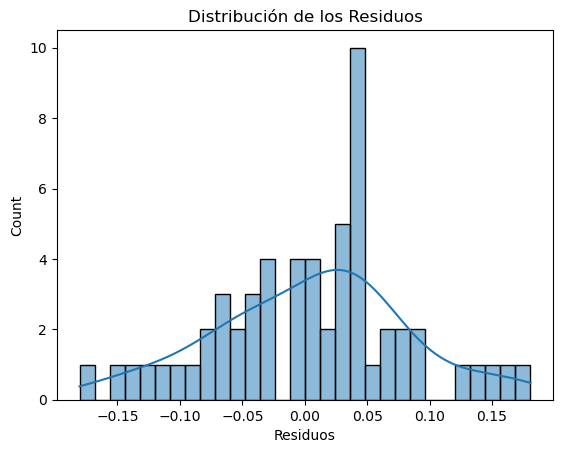

Prueba de normalidad de Shapiro-Wilk: p-value = 0.6310


In [116]:
sns.histplot(residuostn, bins=30, kde=True)
plt.xlabel("Residuos")
plt.title("Distribución de los Residuos")
plt.show()

stat, pn = stats.shapiro(residuostn)
print(f"Prueba de normalidad de Shapiro-Wilk: p-value = {pn:.4f}")

In [117]:
cv_scoresn = cross_val_score(ridge_no_scalingt, X_traint, y_traint, cv=5, scoring="r2")
print(f"R² en validación cruzada: {cv_scoresn.mean():.4f} ± {cv_scoresn.std():.4f}")

R² en validación cruzada: 0.9817 ± 0.0136


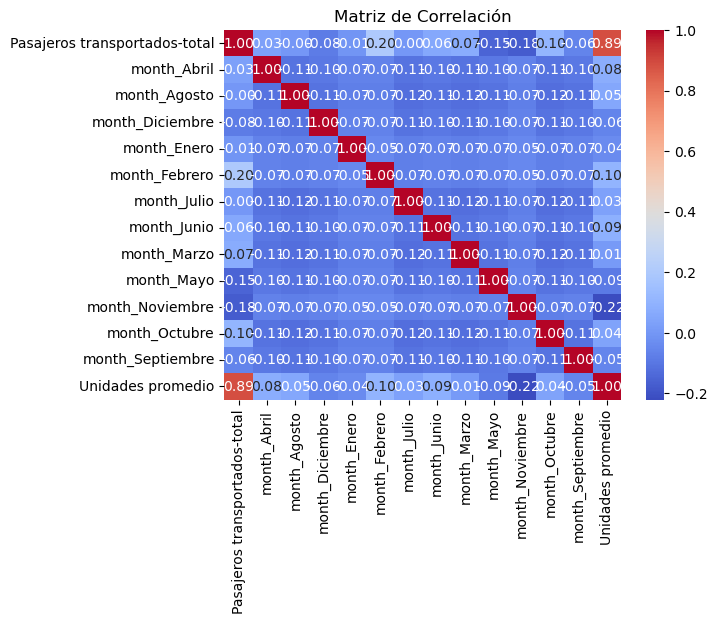

In [118]:
corr_matrix = pd.DataFrame(X_traint, columns=X_traint.columns).corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

##### Conclusion modelo transmetro

En base a las pruebas realizadas podemos determinar que el mejor modelo obtenido corresponde al modelo lineal multifactorial 
simple sin transformacion, con transformacion de las variables. Si bien se intento reducir la posible colinelidad usando regularizacion por ridge. El primer modelo mencionado presenta mejores valores en metricas, ademas de tener cambios no drasticos en los valores. Lo cual se puede observar a continuacion.

In [120]:
# Evaluamos RMSE en validación cruzada
scores = cross_val_score(model_no_scalingt, X_traint, y_traint, cv=5, scoring='neg_mean_squared_error')
rmse_cv = (-scores.mean()) ** 0.5

# Evaluamos RMSE en entrenamiento y prueba
rmse_train = mean_squared_error(y_traint, model_no_scalingt.predict(X_traint), squared=False)
rmse_test = mean_squared_error(y_testt, model_no_scalingt.predict(X_testt), squared=False)

print(f"RMSE en entrenamiento: {rmse_train:.4f}")
print(f"RMSE en prueba: {rmse_test:.4f}")
print(f"RMSE en validación cruzada: {rmse_cv:.4f}")

RMSE en entrenamiento: 0.0565
RMSE en prueba: 0.1289
RMSE en validación cruzada: 0.0945


In [124]:
y_pred_ridge = ridge_no_scalingt.predict(X_testt)
rmse_ridge = mean_squared_error(y_testt, y_pred_ridge, squared=False)

print(f"RMSE con Ridge en prueba: {rmse_ridge:.4f}")

RMSE con Ridge en prueba: 0.1165


### Modelo metro

In [125]:
corr = metro.drop(['month', 'year'], axis=1).corr()['Miles de km recorridos'].sort_values()
corr

Pasajeros transportados-total    0.392200
Unidades en operacion de L-V     0.814802
Unidades en operacion de S-D     0.814802
Miles de km recorridos           1.000000
Name: Miles de km recorridos, dtype: float64

Se observa que la relacion entre las variables unidades en operacion L-V y S-D poseen correlacion identica, al observar la interaccion entre ellas poseen correlacion perfecta(1.0); indicando que una es una version escalada de la otra, ademas de poseer valores casi identicos entre si. Lo anterior podria generar redundancia en el modelo, por lo que la agrupacion de ambas en una sola variable 'Promedio de unidades en operacion' suena conveniente a aplicar en este modelo. 

In [126]:
metro['Unidades promedio'] = (metro['Unidades en operacion de L-V'] + metro['Unidades en operacion de S-D'])/2

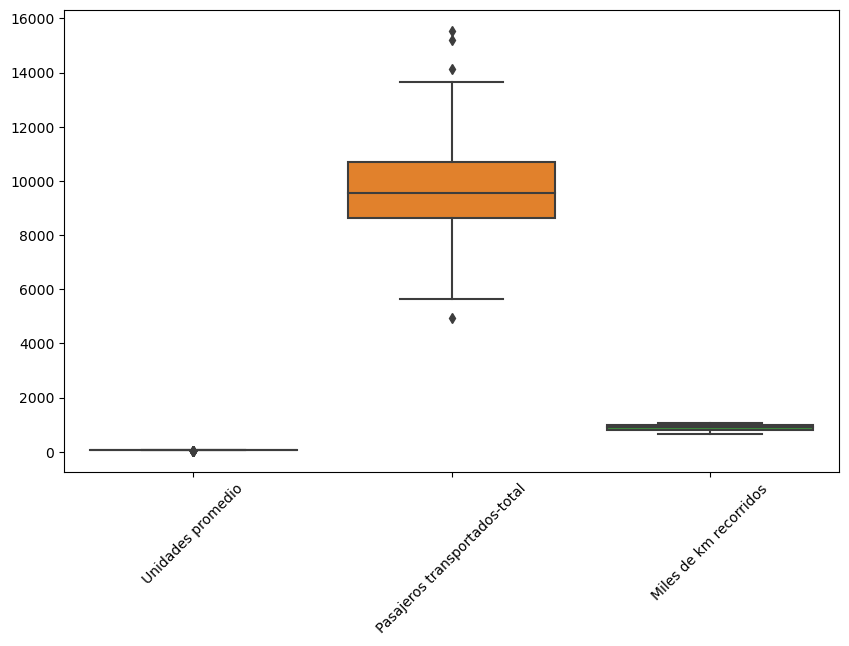

In [127]:
# Boxplot para detectar outliers en las variables más importantes
plt.figure(figsize=(10, 6))
sns.boxplot(data=metro[["Unidades promedio", "Pasajeros transportados-total",'Miles de km recorridos']])
plt.xticks(rotation=45)
plt.show()

Se observan algunos otliers para pasajeros transportados, sin embargo, se mantendran y analizaran con la finalidad de observar si esta variacion es parte de la naturaleza del modelo, conforme a el valor de unidades promedio, se observa que no se forma un boxplot debido a que para los datos obtenidos solo existen dos valores 40 y 50 unidades.

###### Acercamiento modelo metro (No prediccion correcta)

In [20]:
#cambiar la columna month
# Diccionario de mapeo de meses en español a números
meses_a_numeros = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4, "Mayo": 5, "Junio": 6,
    "Julio": 7, "Agosto": 8, "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

# Reemplazar los nombres de los meses por su número
metro["month_num"] = metro["month"].map(meses_a_numeros)

# Eliminar la columna original
metro.drop(columns=["month"], inplace=True)

In [25]:
# Separar variables predictoras y variable objetivo
Xm = metro.drop(columns=["Miles de km recorridos",'Unidades en operacion de L-V','Unidades en operacion de S-D', 'year'])
ym = metro["Miles de km recorridos"]

# División de datos en entrenamiento y prueba
X_trainm, X_testm, y_trainm, y_testm = train_test_split(Xm, ym, test_size=0.2, random_state=42)

In [27]:
# MODELO SIN NORMALIZAR
model_no_scaling_m = LinearRegression()
model_no_scaling_m.fit(X_trainm, y_trainm)
score_no_scaling_m = model_no_scaling_m.score(X_testm, y_testm)

# Normalización de los datos
scaler = StandardScaler()
X_train_scaledm = scaler.fit_transform(X_trainm)
X_test_scaledm = scaler.transform(X_testm)

# MODELO CON NORMALIZACIÓN
model_scaledm = LinearRegression()
model_scaledm.fit(X_train_scaledm, y_trainm)
score_scaledm = model_scaledm.score(X_test_scaledm, y_testm)

# Comparación de coeficientes
coef_no_scalingm = pd.Series(model_no_scaling_m.coef_, index=Xm.columns)
coef_scaledm = pd.Series(model_scaledm.coef_, index=Xm.columns)

# Mostrar resultados
print("\nCoeficientes SIN normalización:\n", coef_no_scalingm)
print("\nCoeficientes CON normalización:\n", coef_scaledm)

print(f"\nR^2 SIN normalización: {score_no_scaling_m:.4f}")
print(f"R^2 CON normalización: {score_scaledm:.4f}")


Coeficientes SIN normalización:
 Pasajeros transportados-total     0.009307
Unidades promedio                18.929003
month_num                         4.816420
dtype: float64

Coeficientes CON normalización:
 Pasajeros transportados-total    18.590600
Unidades promedio                75.091714
month_num                        15.128300
dtype: float64

R^2 SIN normalización: 0.7575
R^2 CON normalización: 0.7575


In [31]:
# Crear un pipeline con transformación polinomial de grado 2
poly_modelm = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Entrenar el modelo con datos normalizados
poly_modelm.fit(X_train_scaledm, y_trainm)

# Evaluar el modelo
score_polym = poly_modelm.score(X_test_scaledm, y_testm)


# Obtener los nombres de las características transformadas
feature_namesm = poly_modelm.named_steps['polynomialfeatures'].get_feature_names_out(X_trainm.columns)

# Obtener los coeficientes del modelo lineal después de la transformación polinomial
coeficientesm = poly_modelm.named_steps['linearregression'].coef_

# Imprimir los coeficientes junto con los nombres de las características
coef_dfm = pd.DataFrame({'Feature': feature_namesm, 'Coeficiente': coeficientesm})
print(coef_dfm)
print(f"R² con regresión polinomial: {score_polym:.4f}")

                                           Feature  Coeficiente
0                                                1     0.000000
1                    Pasajeros transportados-total    12.574572
2                                Unidades promedio    23.087510
3                                        month_num    19.768726
4                  Pasajeros transportados-total^2     8.274920
5  Pasajeros transportados-total Unidades promedio   -13.558045
6          Pasajeros transportados-total month_num     2.672660
7                              Unidades promedio^2   -35.425257
8                      Unidades promedio month_num    -9.082133
9                                      month_num^2   -15.346021
R² con regresión polinomial: 0.6281


Para el modelo de metro, el modelo de regresion lineal simple cumple con las expectativas para predecir en base a su valor de R^2. Conforme la eliminacion de outliers, no supuso un gran problema con la exactitud de los resultados, por lo que manternerlos representa la variabilidad real del sistema

Análisis de residuos, Modelos con y sin outliers: Compara métricas como R² ajustado, error cuadrático medio (MSE) o RMSE.

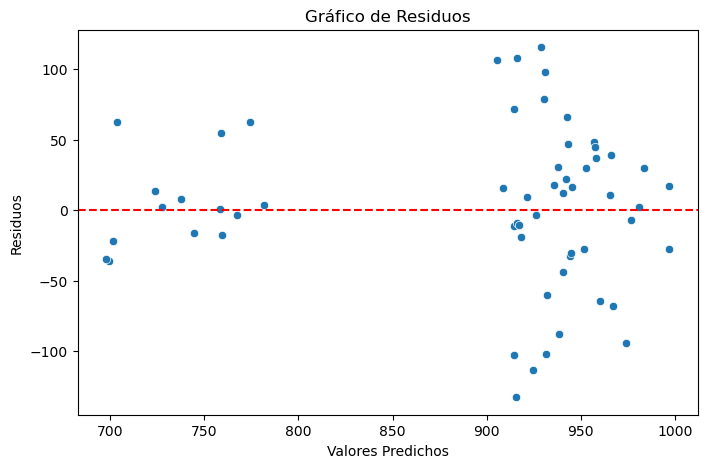

In [36]:
df_metro= pd.DataFrame()
df_metro['y_pred'] = model_no_scaling_m.predict(Xm)
df_metro['residuals'] = ym - df_metro['y_pred']

# Graficar los residuos vs. valores predichos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_metro['y_pred'], y=df_metro['residuals'])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.show()

###### Modelo metro utilizando patron de transmetro

In [128]:
# Convertir 'month' en variables dummy
metro = pd.get_dummies(metro, columns=["month"], drop_first=False)

In [165]:
# Separar variables predictoras y variable objetivo
Xm = metro.drop(columns=["Miles de km recorridos", 'year', 'Unidades en operacion de L-V', 'Unidades en operacion de S-D'])
ym = metro["Miles de km recorridos"]

#Relacion puede ser no lineal sino logaritmica en base a la forma
ym = np.log(ym)

#Los valores predichos altos estan mas dispersos, considerando que la variable pasajeros 
# total de igual manera tiene magnitud grande, suavizar los valores podria ayudar.
Xm[['Pasajeros transportados-total', 'Unidades promedio']] = Xm[['Pasajeros transportados-total',
                                                                 'Unidades promedio']].apply(np.log)

# División de datos en entrenamiento y prueba
X_trainm, X_testm, y_trainm, y_testm = train_test_split(Xm, ym, test_size=0.2, random_state=42)

# MODELO SIN NORMALIZAR
model_no_scalingm = LinearRegression()
model_no_scalingm.fit(X_trainm, y_trainm)
score_no_scalingm = model_no_scalingm.score(X_testm, y_testm)

# Normalización de los datos
scaler = StandardScaler()
X_train_scaledm = scaler.fit_transform(X_trainm)
X_test_scaledm = scaler.transform(X_testm)

# MODELO CON NORMALIZACIÓN
model_scaledm = LinearRegression()
model_scaledm.fit(X_train_scaledm, y_trainm)
score_scaledm = model_scaledm.score(X_test_scaledm, y_testm)

# Comparación de coeficientes
coef_no_scalingm = pd.Series(model_no_scalingm.coef_, index=Xm.columns)
coef_scaledm = pd.Series(model_scaledm.coef_, index=Xm.columns)

# Mostrar resultados
print("\nCoeficientes SIN normalización:\n", coef_no_scalingm)
print("\nCoeficientes CON normalización:\n", coef_scaledm)

print(f"\nR^2 SIN normalización: {score_no_scalingm:.4f}")
print(f"R^2 CON normalización: {score_scaledm:.4f}")


Coeficientes SIN normalización:
 Pasajeros transportados-total    0.125709
Unidades promedio                0.959215
month_Abril                     -0.013996
month_Agosto                     0.013087
month_Diciembre                  0.015119
month_Enero                     -0.071550
month_Febrero                   -0.025757
month_Julio                      0.050540
month_Junio                      0.012721
month_Marzo                     -0.006014
month_Mayo                      -0.007241
month_Noviembre                 -0.019828
month_Octubre                    0.031262
month_Septiembre                 0.021658
dtype: float64

Coeficientes CON normalización:
 Pasajeros transportados-total    0.025716
Unidades promedio                0.084911
month_Abril                     -0.005798
month_Agosto                     0.002025
month_Diciembre                  0.002406
month_Enero                     -0.015933
month_Febrero                   -0.006595
month_Julio                      0.

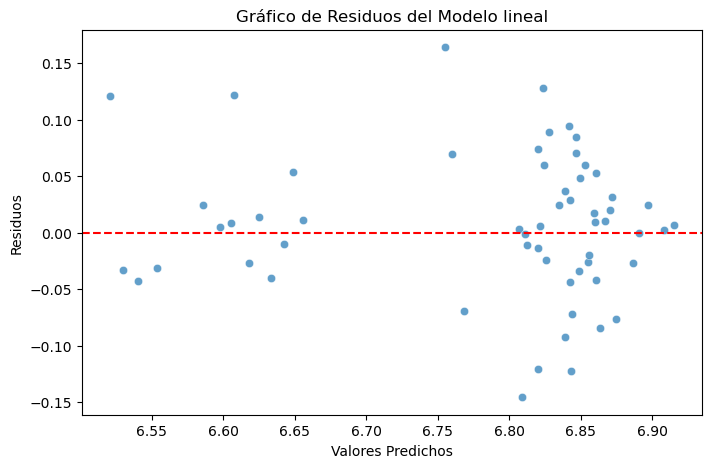

In [166]:
# Obtener predicciones del modelo polinomial
y_predm = model_no_scalingm.predict(Xm)

# Calcular residuos
residuosm = ym - y_predm

# Gráfico de dispersión de residuos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_predm, y=residuosm, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')  # Línea horizontal en 0
plt.xlabel("Valores Predichos")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos del Modelo lineal")
plt.show()

In [167]:
mse = mean_squared_error(ym, y_predm)
rmse=np.sqrt(mse)
print(f"RMSE:{rmse:.4f}")
mae = mean_absolute_error(ym, y_predm)
print(f"MAE: {mae:.4f}")
mape = (abs(residuosm) / abs(ym)).mean() * 100
print(f"MAPE: {mape:.2f}%")

RMSE:0.0629
MAE: 0.0480
MAPE: 0.71%


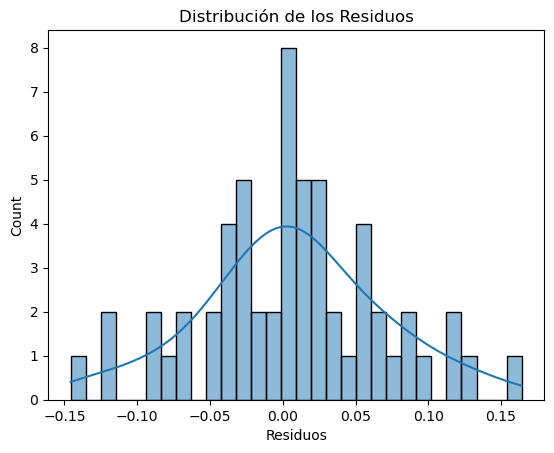

Prueba de normalidad de Shapiro-Wilk: p-value = 0.3795


In [168]:
sns.histplot(residuosm, bins=30, kde=True)
plt.xlabel("Residuos")
plt.title("Distribución de los Residuos")
plt.show()

stat, pn = stats.shapiro(residuostn)
print(f"Prueba de normalidad de Shapiro-Wilk: p-value = {p:.4f}")

In [169]:
cv_scoresm = cross_val_score(model_no_scalingm, X_trainm, y_trainm, cv=5, scoring="r2")
print(f"R² en validación cruzada: {cv_scoresm.mean():.4f} ± {cv_scoresm.std():.4f}")

R² en validación cruzada: 0.3146 ± 0.1581


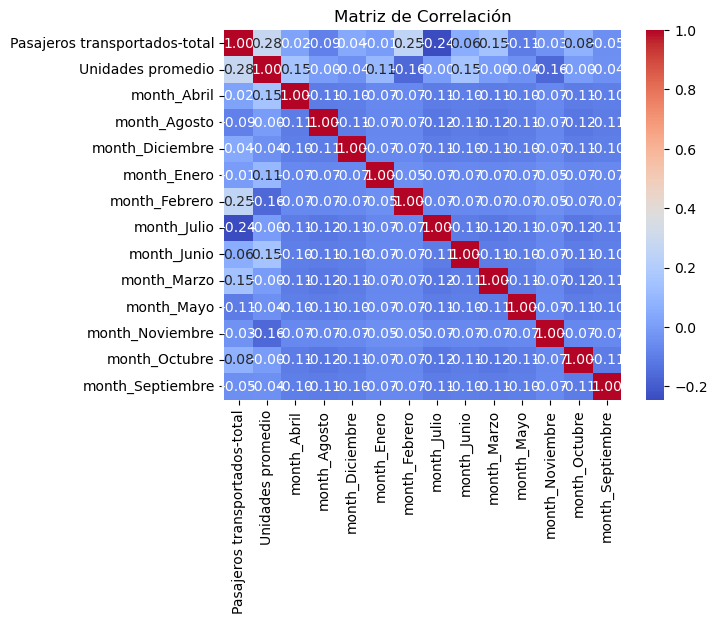

In [170]:
corr_matrixm = pd.DataFrame(X_trainm, columns=X_trainm.columns).corr()
sns.heatmap(corr_matrixm, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

**Modelo polinomial**

In [174]:
# Crear un pipeline con transformación polinomial de grado 3
poly_modelm = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())

# Entrenar el modelo con datos normalizados
poly_modelm.fit(X_train_scaledm, y_trainm)

# Evaluar el modelo
score_polym = poly_modelm.score(X_test_scaledm, y_testm)


# Obtener los nombres de las características transformadas
feature_namesm = poly_modelm.named_steps['polynomialfeatures'].get_feature_names_out(X_trainm.columns)

# Obtener los coeficientes del modelo lineal después de la transformación polinomial
coeficientesm = poly_modelm.named_steps['linearregression'].coef_

# Imprimir los coeficientes junto con los nombres de las características
coef_dfm = pd.DataFrame({'Feature': feature_namesm, 'Coeficiente': coeficientesm})
print(coef_dfm)
print(f"R² con regresión polinomial: {score_polym:.4f}")

                                Feature   Coeficiente
0                                     1 -3.303521e+09
1         Pasajeros transportados-total -1.407247e+09
2                     Unidades promedio  5.742667e+08
3                           month_Abril  6.027255e+07
4                          month_Agosto -2.194327e+08
..                                  ...           ...
675  month_Noviembre month_Septiembre^2  1.204047e+08
676                     month_Octubre^3  1.065278e+08
677    month_Octubre^2 month_Septiembre -3.337879e+08
678    month_Octubre month_Septiembre^2 -1.579952e+08
679                  month_Septiembre^3  5.230099e+08

[680 rows x 2 columns]
R² con regresión polinomial: -43226055635367324811264.0000


###### Conclusion, modelo ideal

Debido a la heterocedasticidad del modelo anterior, se planteo eliminar valores atipicos con la finalidad de ver si al volver a ajustar el modelo existiria una correccion, no obstante, no se observo cambio drastico en el fenomeno de abanico obtenido en el grafico de abanico. 

In [22]:
import statsmodels.api as sm
# Supongamos que tienes un DataFrame df con tus variables independientes (X) y dependiente (y)
Xm2 = metro.drop(columns=["Miles de km recorridos", 'year', 'Unidades en operacion de L-V', 'Unidades en operacion de S-D'])  # Reemplaza con tus variables
ym2 = metro['Miles de km recorridos']  # Variable dependiente

# Agregar una constante para la intersección en el modelo
Xm2 = sm.add_constant(Xm2)

for col in Xm2.columns:
    try:
        Xm2[col] = Xm2[col].astype(float)
    except ValueError:
        print(f"❌ La columna '{col}' aún tiene valores no numéricos")
# Ajustar modelo de regresión
modelom2 = sm.OLS(ym2, Xm2).fit()

# Obtener Cook's Distance
influence = modelom2.get_influence()
cooks_d, _ = influence.cooks_distance

# Definir un umbral: Regla común -> 4/N (N = número de observaciones)
threshold = 4 / len(Xm2)

# Identificar puntos influyentes
outliers_cooks = np.where(cooks_d > threshold)[0]

print(f'Puntos influyentes según Cook\'s Distance: {outliers_cooks}')

❌ La columna 'month' aún tiene valores no numéricos


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
plt.figure(figsize=(10, 5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", use_line_collection=True)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Umbral ({threshold:.4f})')
plt.xlabel('Índice de la Observación')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance para cada observación")
plt.legend()
plt.show()

In [193]:
dffits_values = influence.dffits[0]

# Umbral común: 2 * sqrt(k / N), donde k es el número de predictores y N el número de observaciones
k = Xm2.shape[1] - 1  # Número de predictores
N = Xm2.shape[0]  # Número de observaciones
threshold_dffits = 2 * np.sqrt(k / N)

# Identificar puntos influyentes
outliers_dffits = np.where(np.abs(dffits_values) > threshold_dffits)[0]

print(f'Puntos influyentes según DFFITS: {outliers_dffits}')

Puntos influyentes según DFFITS: [36 38 39 55]


In [194]:
dfbeta = modelom2.get_influence().dfbetas
print(dfbeta[[36, 38, 55], :])  # Muestra impacto en los coeficientes

[[ 0.30585234  0.15943885 -0.39691736  0.21858047  0.21072641  0.16592891
  -1.20798332  0.13468648  0.22788418  0.20745039  0.17854476  0.20366211
   0.1497632   0.18823274  0.2096451 ]
 [ 0.11330341  0.03601017 -0.15087126  0.1252917   0.12376926  0.10509607
   0.09971174  0.09914118  0.12673664  0.12306841 -0.92424442  0.12221579
   0.10077771  0.11834854  0.12354187]
 [-0.09393489 -0.33680307  0.26488867 -0.17661523  1.10587348 -0.10798252
  -0.08140066 -0.07740349 -0.19873346 -0.15201278 -0.09428456 -0.1439991
  -0.07622678 -0.11284189 -0.15673245]]


Intento de entrenar modelo para observar algun cambio en el modelo, se muestra comportamiento similar, por lo que la implementacion de una regresion robusta puede resultar conveniente para reducir la heterocedasticidad.

In [201]:
metro_sin_outliers = metro.drop(index=[36, 38, 55])

# Repetir el proceso sin los outliers
Xm2_sin = metro_sin_outliers.drop(columns=["Miles de km recorridos", 'year', 'Unidades en operacion de L-V', 'Unidades en operacion de S-D'])
ym2_sin = metro_sin_outliers['Miles de km recorridos']

#Relacion puede ser no lineal sino logaritmica en base a la forma
ym2_sin = np.log(ym2_sin)

#Los valores predichos altos estan mas dispersos, considerando que la variable pasajeros 
# total de igual manera tiene magnitud grande, suavizar los valores podria ayudar.
Xm2_sin[['Pasajeros transportados-total', 'Unidades promedio']] = Xm2_sin[['Pasajeros transportados-total',
                                                                 'Unidades promedio']].apply(np.sqrt)

# División de datos en entrenamiento y prueba
X_trainm, X_testm, y_trainm, y_testm = train_test_split(Xm2_sin, ym2_sin, test_size=0.2, random_state=42)

# MODELO SIN NORMALIZAR
model_no_scalingm = LinearRegression()
model_no_scalingm.fit(X_trainm, y_trainm)
score_no_scalingm = model_no_scalingm.score(X_testm, y_testm)

# Normalización de los datos
scaler = StandardScaler()
X_train_scaledm = scaler.fit_transform(X_trainm)
X_test_scaledm = scaler.transform(X_testm)

# MODELO CON NORMALIZACIÓN
model_scaledm = LinearRegression()
model_scaledm.fit(X_train_scaledm, y_trainm)
score_scaledm = model_scaledm.score(X_test_scaledm, y_testm)

# Comparación de coeficientes
coef_no_scalingm = pd.Series(model_no_scalingm.coef_, index=Xm.columns)
coef_scaledm = pd.Series(model_scaledm.coef_, index=Xm.columns)

# Mostrar resultados
print("\nCoeficientes SIN normalización:\n", coef_no_scalingm)
print("\nCoeficientes CON normalización:\n", coef_scaledm)

print(f"\nR^2 SIN normalización: {score_no_scalingm:.4f}")
print(f"R^2 CON normalización: {score_scaledm:.4f}")


Coeficientes SIN normalización:
 Pasajeros transportados-total    0.003294
Unidades promedio                0.296204
month_Abril                     -0.055054
month_Agosto                     0.023781
month_Diciembre                  0.003908
month_Enero                      0.030648
month_Febrero                   -0.078940
month_Julio                      0.021289
month_Junio                     -0.000708
month_Marzo                      0.020236
month_Mayo                      -0.014897
month_Noviembre                 -0.014904
month_Octubre                    0.037245
month_Septiembre                 0.027396
dtype: float64

Coeficientes CON normalización:
 Pasajeros transportados-total    0.035321
Unidades promedio                0.095748
month_Abril                     -0.014982
month_Agosto                     0.003982
month_Diciembre                  0.001969
month_Enero                      0.008466
month_Febrero                   -0.021848
month_Julio                      0.

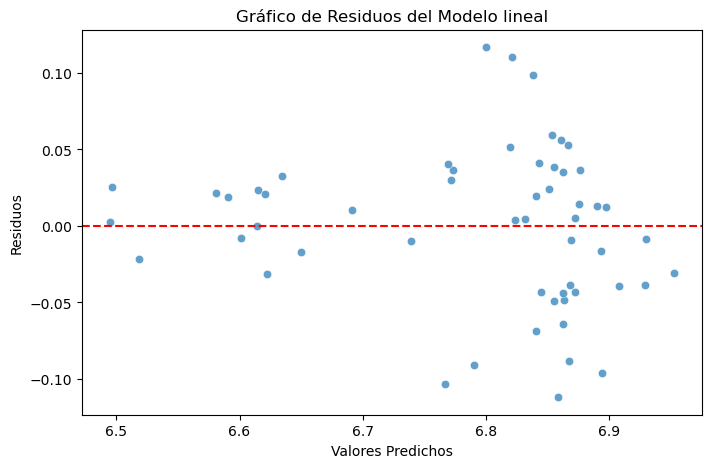

In [202]:
# Obtener predicciones del modelo lineal
y_predm = model_no_scalingm.predict(Xm2_sin)

# Calcular residuos
residuosm = ym2_sin - y_predm

# Gráfico de dispersión de residuos
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_predm, y=residuosm, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')  # Línea horizontal en 0
plt.xlabel("Valores Predichos")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos del Modelo lineal")
plt.show()

Generacion de modelo de regresion robusto

In [191]:
modelo_robusto = sm.RLM(ym2, Xm2).fit()
print(modelo_robusto.summary())

                      Robust linear Model Regression Results                      
Dep. Variable:     Miles de km recorridos   No. Observations:                   58
Model:                                RLM   Df Residuals:                       44
Method:                              IRLS   Df Model:                           13
Norm:                              HuberT                                         
Scale Est.:                           mad                                         
Cov Type:                              H1                                         
Date:                    Mon, 10 Feb 2025                                         
Time:                            00:18:49                                         
No. Iterations:                        13                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

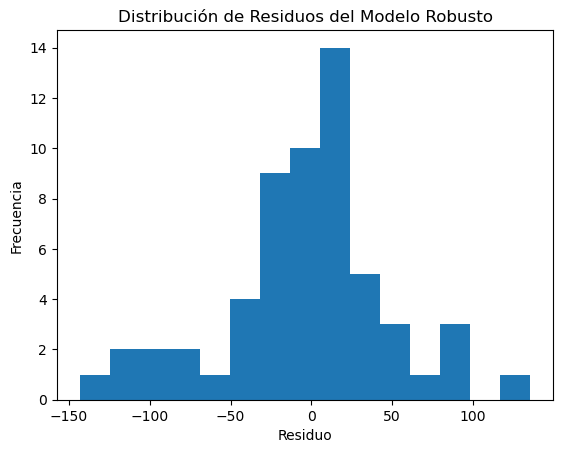

In [203]:
residuos = modelo_robusto.resid  # Obtener residuos
plt.hist(residuos, bins=15)
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.title("Distribución de Residuos del Modelo Robusto")
plt.show()

Los resultados muestran un incremento de 0.0124 miles de km por cada pasajero de manera muy significativa <0.001. De igual manera, el incremento en unidades afecta 18.3039 miles de km al mes de manera muy significativa. 
Al contrario para el mes de febrero se observa una disminucion 59.9 km menos con el mes de abril de manera significativa.
Por ultimo para confirmar que el modelo capturo la relacion podemos observar que al graficar la distribucion de los residuos es simetrica.

In [ ]:
'''  HACER PREDICCIONES EN BASE AL MODELO ANTERIOR
# Supongamos que tienes nuevas observaciones (nuevas variables independientes)
X_nuevo = sm.add_constant([[500, 30, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])  
# La primera columna es la constante (bias), luego los valores de las variables en orden.

# Predecir los kilómetros recorridos
prediccion = rlm_model.predict(X_nuevo)
print(prediccion)
'''